# Regression - Predicting House Prices

### Can the house prices of king county be predicted?
This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015. 

## We can do the following analysis using the library.
### Exploratory Analysis
- Plot a distribution and box plot for the price variable. Find out if there are any outliers and list them.
- Find out which variables are highly correlated with 'price'.
- Find out which zip codes have the highest median house 'price'. Do a bar plot to depict the top 10.
- Find out if there are any missing values in the dataset and your strategy for imputing those.
- Do some variables need feature engineering or transformation, if they need to be used to predict prices. Explain what transformations you will apply.
- Model Building
    - Build a regression model to predict the prices.
- Evaluation
    - Calculate the RMSE and R-Squared value on the test data set.
    - Build the linear model with L1 and L2 regularization parameters. Do a Grid Search for to find optimal values for hyper parameters.
        - Lasso
        - Ridge
    - Draw a diagram to depict RMSE values for different hyper parameters and show the lowest RMSE at optimal value for L1 and L2 parameters.
- Models Comparison
    - Build the following models and find the best performing model with lowest RMSE value.
    - Ridge
    - Lasso
    - Elastic Net (With Lasso and Ridge regularizations)
    - Decision Tree
    - Random Forest

In [ ]:
!pip install pyspark

!apt-get install openjdk-8-jdk-headless -qq > /dev/null

!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz

!tar xf spark-3.2.1-bin-hadoop2.7.tgz

!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"

import findspark

findspark.init()

import pyspark

     |████████████████████████████████| 281.4 MB 33 kB/s 
     |████████████████████████████████| 198 kB 62.6 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=b870752b540d389af3eb8739c77c826c0a0978d16ef4f14a8737ff90cf6137fb
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [ ]:
### Initialize the spark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [ ]:
import pyspark.ml as ml

In [ ]:
# Load the dataset
housing_df  = spark.read.csv('kc_house_data.csv',inferSchema=True,header=True)

In [ ]:
housing_df.show(5, truncate=False)

+----------+---------------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+
|id        |date           |price   |bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|lat    |long    |sqft_living15|sqft_lot15|
+----------+---------------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+
|7129300520|20141013T000000|221900.0|3       |1.0      |1180       |5650    |1.0   |0         |0   |3        |7    |1180      |0            |1955    |0           |98178  |47.5112|-122.257|1340         |5650      |
|6414100192|20141209T000000|538000.0|3       |2.25     |2570       |7242    |2.0   |0         |0   |3        |7    |2170      |400          |195

In [ ]:
# Let's cache the dataset
housing_df.cache()
housing_df.printSchema()

root
 |-- id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- price: double (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- sqft_living: integer (nullable = true)
 |-- sqft_lot: integer (nullable = true)
 |-- floors: double (nullable = true)
 |-- waterfront: integer (nullable = true)
 |-- view: integer (nullable = true)
 |-- condition: integer (nullable = true)
 |-- grade: integer (nullable = true)
 |-- sqft_above: integer (nullable = true)
 |-- sqft_basement: integer (nullable = true)
 |-- yr_built: integer (nullable = true)
 |-- yr_renovated: integer (nullable = true)
 |-- zipcode: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- sqft_living15: integer (nullable = true)
 |-- sqft_lot15: integer (nullable = true)



In [ ]:
#How many records in the dataset?
housing_df.count()

21613

In [ ]:
housing_df.describe().show()

+-------+--------------------+---------------+------------------+-----------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+-----------------+------------------+
|summary|                  id|           date|             price|         bedrooms|         bathrooms|       sqft_living|          sqft_lot|            floors|          waterfront|               view|         condition|             grade|        sqft_above|     sqft_basement|          yr_built|      yr_renovated|           zipcode|                lat|               long|    sqft_living15|        sqft_lot15|
+-------+--------------------+---------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------

## Exploring the data

In [ ]:
#Summary Statistics of price and sqft_living
housing_df.describe("price", "sqft_living").show()

+-------+------------------+------------------+
|summary|             price|       sqft_living|
+-------+------------------+------------------+
|  count|             21613|             21613|
|   mean| 540088.1417665294|2079.8997362698374|
| stddev|367127.19648270035| 918.4408970468096|
|    min|           75000.0|               290|
|    max|         7700000.0|             13540|
+-------+------------------+------------------+



In [ ]:
#We can also explicitly ask for specific stats about columns by passing appropriate stats functions
from pyspark.sql.functions import mean, min, max
housing_df.select([max('price'), mean('price'), min('price')] ).show()

+----------+-----------------+----------+
|max(price)|       avg(price)|min(price)|
+----------+-----------------+----------+
| 7700000.0|540088.1417665294|   75000.0|
+----------+-----------------+----------+



In [ ]:
housing_df.select([mean('price'), mean('sqft_living')] ).show()

+-----------------+------------------+
|       avg(price)|  avg(sqft_living)|
+-----------------+------------------+
|540088.1417665294|2079.8997362698374|
+-----------------+------------------+



In [ ]:
#Is there any relationship between waterfront and view?
bed_bath_df = housing_df.select(['waterfront', 'view'] )
bed_bath_df.show(10)

+----------+----+
|waterfront|view|
+----------+----+
|         0|   0|
|         0|   0|
|         0|   0|
|         0|   0|
|         0|   0|
|         0|   0|
|         0|   0|
|         0|   0|
|         0|   0|
|         0|   0|
+----------+----+
only showing top 10 rows



In [ ]:
#Using crosstab function
bed_bath_df.stat.crosstab("view", "waterfront").show()

+---------------+-----+---+
|view_waterfront|    0|  1|
+---------------+-----+---+
|              0|19489|  0|
|              1|  331|  1|
|              2|  955|  8|
|              3|  491| 19|
|              4|  184|135|
+---------------+-----+---+



In [ ]:
#Mean and standard deviation of prices for houses by different conditions
from pyspark.sql.functions import avg, stddev

price_conditon_avg_df = housing_df.groupBy('condition').agg(avg('price'))
price_conditon_avg_df.show()

+---------+-----------------+
|condition|       avg(price)|
+---------+-----------------+
|        1|334431.6666666667|
|        3|542012.5781483857|
|        5|612418.0893592004|
|        4|521200.3900334566|
|        2|327287.1453488372|
+---------+-----------------+



In [ ]:
housing_df.groupBy('condition').agg(stddev('price')).show()

+---------+------------------+
|condition|stddev_samp(price)|
+---------+------------------+
|        1|271172.80483730906|
|        3| 364449.0623431633|
|        5| 410971.9225399082|
|        4| 358516.2313502131|
|        2|245418.41321957213|
+---------+------------------+



In [ ]:
#Plotting distribution of price
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

In [ ]:
housing_price_pd = housing_df.select('price').toPandas()

In [ ]:
housing_df

DataFrame[id: bigint, date: string, price: double, bedrooms: int, bathrooms: double, sqft_living: int, sqft_lot: int, floors: double, waterfront: int, view: int, condition: int, grade: int, sqft_above: int, sqft_basement: int, yr_built: int, yr_renovated: int, zipcode: int, lat: double, long: double, sqft_living15: int, sqft_lot15: int]

In [ ]:
housing_price_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   21613 non-null  float64
dtypes: float64(1)
memory usage: 169.0 KB


In [ ]:
housing_price_pd.head()

,price
0,221900.0
1,538000.0
2,180000.0
3,604000.0
4,510000.0


In [ ]:
import pandas as pd

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


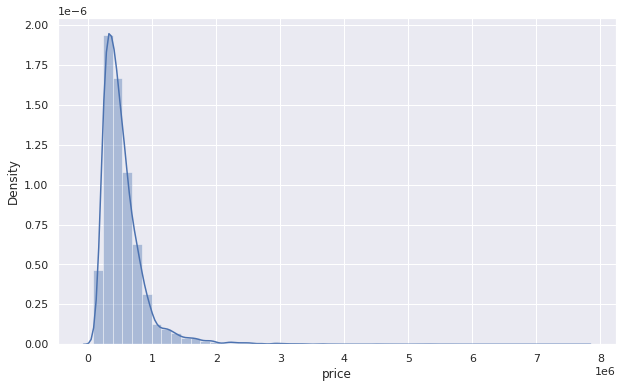

In [ ]:
#Density Plot
sn.set(rc={"figure.figsize": (10, 6)})
sn.distplot(pd.to_numeric(housing_price_pd['price']), norm_hist=True)

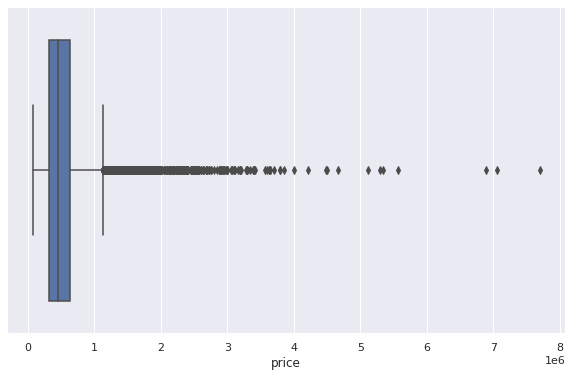

In [ ]:
#Boxplot
sn.boxplot(x= pd.to_numeric(housing_price_pd['price']))

We can observe there are many outliers in the dataset as far as price is concerned

In [ ]:
#Correlation between price and sqft_living
column_labels = ['price','sqft_living', 'sqft_lot', 'bedrooms','bathrooms', \
         'floors', 'sqft_above', 'sqft_basement','yr_built','yr_renovated', \
        'sqft_living15', 'sqft_lot15']

In [ ]:
housing_df.stat.corr( 'price', 'sqft_living' )

0.7020350546118005

sqft_living is highly correated with price

In [ ]:
# Which factors are hightly correlated with price
import numpy as np
from pyspark.mllib.stat import Statistics


In [ ]:
column_corr = Statistics.corr(housing_df.rdd.map(lambda x:
                         np.array([x['price'],
                                   x['sqft_living'],
                                   x['sqft_lot'],
                                   x['bedrooms'],
                                   x['bathrooms'],
                                   x['floors'],
                                   x['sqft_above'],
                                   x['sqft_basement'],
                                   x['yr_built'],
                                   x['yr_renovated'],
                                   x['sqft_living15'],
                                   x['sqft_lot15']
                                  ])), method='pearson')

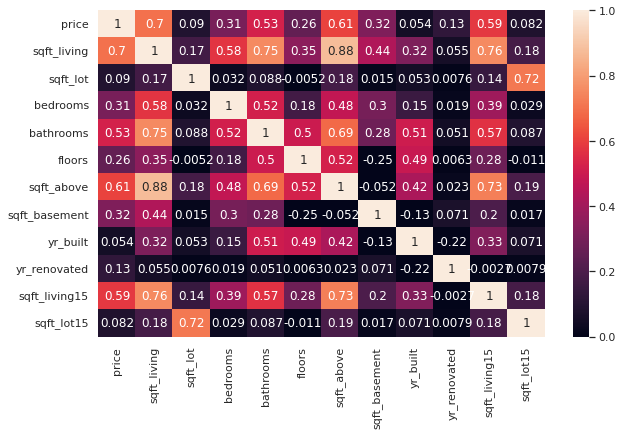

In [ ]:
sn.heatmap( column_corr, vmin=0,
          vmax=1,
          annot= True,
          xticklabels = column_labels,
          yticklabels = column_labels )

The factors sqft_living, number of bathrooms, sqft_living15 and sqft_above seem to be highly correlated with price and can be good predictors for price

In [ ]:
# Which zipcodes have high median prices
from pyspark.sql.functions import desc

price_by_zipcodes_df = housing_df.groupBy('zipcode').agg(avg('price')).sort( desc( 'avg(price)') )

In [ ]:
price_by_zipcodes_df.toPandas()[0:10]

,zipcode,avg(price)
0,98039,2.160607e+06
1,98004,1.355927e+06
2,98040,1.194230e+06
3,98112,1.095499e+06
4,98102,9.012583e+05
5,98109,8.796236e+05
6,98105,8.628252e+05
7,98006,8.596848e+05
8,98119,8.494480e+05
9,98005,8.101649e+05


In [ ]:
top_10_zipcodes = price_by_zipcodes_df.toPandas()[0:10]

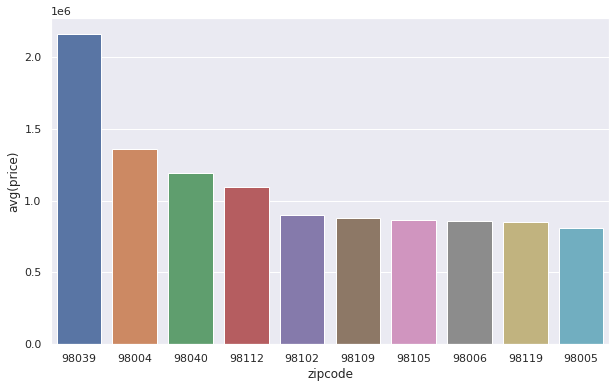

In [ ]:
sn.barplot( data = top_10_zipcodes,
          x='zipcode',
          y='avg(price)',
          order = top_10_zipcodes.zipcode)

In [ ]:
#Any null(missings) values
from pyspark.sql.functions import isnull

house_df_clean = housing_df.na.drop( how = 'any' )

In [ ]:
house_df_clean.count() == housing_df.count()

True

Both the row counts are same. Hence no null values in any of the columns.

## Feature Engineering
- Creating or transforming features is a criticial step for building models. For example, if a variable is skewed, it can be log transformed to make it more normal. Also, derive features from existing features, which can explain or predict the response variable.

### Log transformation for price variable
- price variable is right skewed. We can apply log transformation to make it normally distributed.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


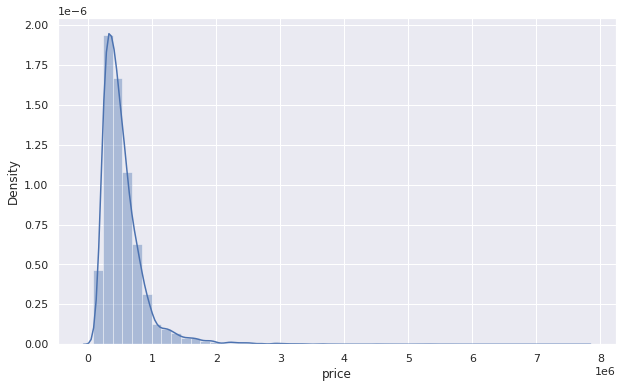

In [ ]:
sn.set(rc={"figure.figsize": (10, 6)})
sn.distplot(pd.to_numeric(housing_price_pd['price']), norm_hist=True)

In [ ]:
from pyspark.sql.functions import col, log
housing_df = housing_df.withColumn( 'log_price', log('price') )

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


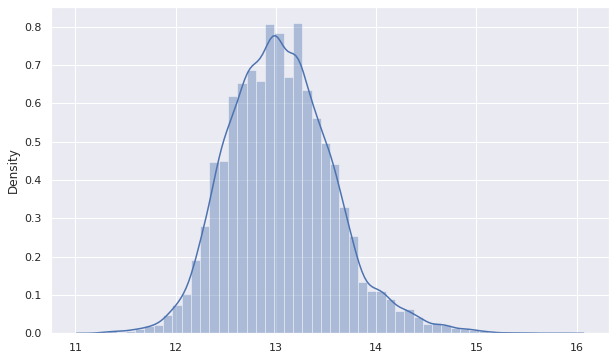

In [ ]:
sn.set(rc={"figure.figsize": (10, 6)})
sn.distplot(housing_df.select('log_price').toPandas(), norm_hist=True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


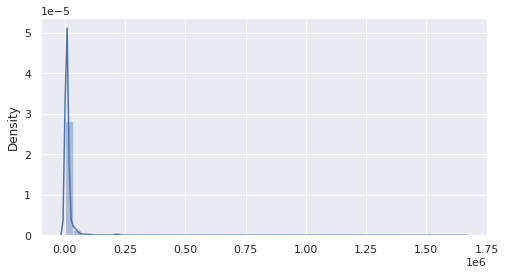

In [ ]:
#Log transformation for sqft_living variable
sn.set(rc={"figure.figsize": (8, 4)})
sn.distplot(housing_df.select('sqft_lot').toPandas(), norm_hist=True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


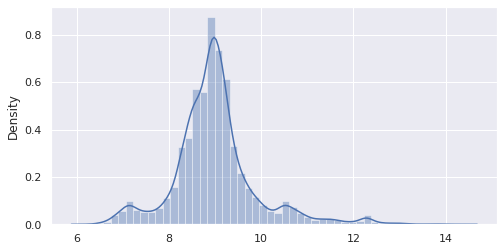

In [ ]:
housing_df = housing_df.withColumn( 'log_sqft_lot', log('sqft_lot') )
sn.distplot(housing_df.select('log_sqft_lot').toPandas(), norm_hist=True)

In [ ]:
#Correlating log transformed of price and sqft_living
housing_df.stat.corr( 'price', 'sqft_lot' )

0.0896608605871003

In [ ]:
housing_df.stat.corr( 'log_price', 'log_sqft_lot' )

0.13772713692112706

In [ ]:
housing_df.stat.corr( 'log_price', 'sqft_lot' )

0.09962221990069252

#### Calculating age of the house
- Age of the house may be influencing the price of the house.
- Assuming 2015 as the base year, how old the house is can be computed and used as a variable to predict the house prices

In [ ]:
from pyspark.sql.functions import lit

housing_df = housing_df.withColumn("age", lit(2015) - col('yr_built'))

In [ ]:
housing_df.show( 5 )

+----------+---------------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+------------------+-----------------+---+
|        id|           date|   price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|    lat|    long|sqft_living15|sqft_lot15|         log_price|     log_sqft_lot|age|
+----------+---------------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+------------------+-----------------+---+
|7129300520|20141013T000000|221900.0|       3|      1.0|       1180|    5650|   1.0|         0|   0|        3|    7|      1180|            0|    1955|           0|  98178|47.5112|-122.257|         1340|      5650|12.309982108920686|8.6

In [ ]:
housing_df.columns

['id',
 'date',
 'price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'log_price',
 'log_sqft_lot',
 'age']

In [ ]:
#When was the house last rennovated?
housing_df = housing_df.withColumn("rennovate_age", lit(2015) - col('yr_renovated'))
housing_df.show(2)

+----------+---------------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+------------------+-----------------+---+-------------+
|        id|           date|   price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|    lat|    long|sqft_living15|sqft_lot15|         log_price|     log_sqft_lot|age|rennovate_age|
+----------+---------------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+------------------+-----------------+---+-------------+
|7129300520|20141013T000000|221900.0|       3|      1.0|       1180|    5650|   1.0|         0|   0|        3|    7|      1180|            0|    1955|           0|  98178|47.5112|-122.257|     

In [ ]:
#Keep a copy of the original dataframe for later use
housing_df1 = housing_df

In [ ]:
#Columns that will be used as features and their types
continuous_features = ['sqft_living', 'bedrooms', 'bathrooms', 'floors',
                    'log_sqft_lot', 'age', 'sqft_above',
                    'sqft_living15', 'sqft_lot15', 'rennovate_age']

categorical_features = ['zipcode', 'waterfront',
                      'grade', 'condition',
                      'view']

In [ ]:
#Encoding all categorical features
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, PolynomialExpansion, VectorIndexer

In [ ]:
# create object of StringIndexer class and specify input and output column
SI_zipcode = StringIndexer(inputCol='zipcode',outputCol='zipcode_Index')
SI_waterfront = StringIndexer(inputCol='waterfront',outputCol='waterfront_Index')
SI_grade = StringIndexer(inputCol='grade',outputCol='grade_Index')
SI_condition = StringIndexer(inputCol='condition',outputCol='condition_Index')
SI_view = StringIndexer(inputCol='view',outputCol='view_Index')


# transform the data
housing_df1 = SI_zipcode.fit(housing_df1).transform(housing_df1)
housing_df1 = SI_waterfront.fit(housing_df1).transform(housing_df1)
housing_df1 = SI_grade.fit(housing_df1).transform(housing_df1)
housing_df1 = SI_condition.fit(housing_df1).transform(housing_df1)
housing_df1 = SI_view.fit(housing_df1).transform(housing_df1)


# view the transformed data
housing_df1.select('zipcode', 'zipcode_Index', 'waterfront', 'waterfront_Index', 'grade', 'grade_Index', 'condition', 'condition_Index','view', 'view_Index').show(10)


+-------+-------------+----------+----------------+-----+-----------+---------+---------------+----+----------+
|zipcode|zipcode_Index|waterfront|waterfront_Index|grade|grade_Index|condition|condition_Index|view|view_Index|
+-------+-------------+----------+----------------+-----+-----------+---------+---------------+----+----------+
|  98178|         45.0|         0|             0.0|    7|        0.0|        3|            0.0|   0|       0.0|
|  98125|         17.0|         0|             0.0|    7|        0.0|        3|            0.0|   0|       0.0|
|  98028|         34.0|         0|             0.0|    6|        3.0|        3|            0.0|   0|       0.0|
|  98136|         44.0|         0|             0.0|    7|        0.0|        5|            2.0|   0|       0.0|
|  98074|         14.0|         0|             0.0|    8|        1.0|        3|            0.0|   0|       0.0|
|  98053|         19.0|         0|             0.0|   11|        5.0|        3|            0.0|   0|    

In [ ]:
# create object and specify input and output column
OHE = OneHotEncoder(inputCols=['zipcode_Index', 'waterfront_Index','grade_Index', 'condition_Index', 'view_Index' ],outputCols=['zipcode_vec', 'waterfront_vec','grade_vec', 'condition_vec', 'view_vec'])

# transform the data
housing_df1 = OHE.fit(housing_df1).transform(housing_df1)

# view and transform the data
housing_df1.select('zipcode', 'zipcode_Index', 'zipcode_vec', 'waterfront', 'waterfront_Index', 'waterfront_vec','grade', 'grade_Index', 'grade_vec','condition', 'condition_Index','condition_vec','view', 'view_Index', 'view_vec').show(10)

+-------+-------------+---------------+----------+----------------+--------------+-----+-----------+--------------+---------+---------------+-------------+----+----------+-------------+
|zipcode|zipcode_Index|    zipcode_vec|waterfront|waterfront_Index|waterfront_vec|grade|grade_Index|     grade_vec|condition|condition_Index|condition_vec|view|view_Index|     view_vec|
+-------+-------------+---------------+----------+----------------+--------------+-----+-----------+--------------+---------+---------------+-------------+----+----------+-------------+
|  98178|         45.0|(69,[45],[1.0])|         0|             0.0| (1,[0],[1.0])|    7|        0.0|(11,[0],[1.0])|        3|            0.0|(4,[0],[1.0])|   0|       0.0|(4,[0],[1.0])|
|  98125|         17.0|(69,[17],[1.0])|         0|             0.0| (1,[0],[1.0])|    7|        0.0|(11,[0],[1.0])|        3|            0.0|(4,[0],[1.0])|   0|       0.0|(4,[0],[1.0])|
|  98028|         34.0|(69,[34],[1.0])|         0|             0.0| (1

In [ ]:
housing_df1.printSchema()

root
 |-- id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- price: double (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- sqft_living: integer (nullable = true)
 |-- sqft_lot: integer (nullable = true)
 |-- floors: double (nullable = true)
 |-- waterfront: integer (nullable = true)
 |-- view: integer (nullable = true)
 |-- condition: integer (nullable = true)
 |-- grade: integer (nullable = true)
 |-- sqft_above: integer (nullable = true)
 |-- sqft_basement: integer (nullable = true)
 |-- yr_built: integer (nullable = true)
 |-- yr_renovated: integer (nullable = true)
 |-- zipcode: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- sqft_living15: integer (nullable = true)
 |-- sqft_lot15: integer (nullable = true)
 |-- log_price: double (nullable = true)
 |-- log_sqft_lot: double (nullable = true)
 |-- age: integer (nullable = true)
 |-- rennovate_age: integer (

In [ ]:
housing_df1.show(5)

+----------+---------------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+------------------+-----------------+---+-------------+-------------+----------------+-----------+---------------+----------+---------------+--------------+--------------+-------------+-------------+
|        id|           date|   price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|    lat|    long|sqft_living15|sqft_lot15|         log_price|     log_sqft_lot|age|rennovate_age|zipcode_Index|waterfront_Index|grade_Index|condition_Index|view_Index|    zipcode_vec|waterfront_vec|     grade_vec|condition_vec|     view_vec|
+----------+---------------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+---

In [ ]:
#Create vectors from all features column
featureCols = continuous_features + ['zipcode_vec',
                                   'waterfront_vec',
                                   'grade_vec',
                                   'condition_vec',
                                   'view_vec']

In [ ]:
featureCols

# Using Linear Regressionn - Establish linear relationship between Y & X variables

#Ideally we want to achieve price = B1*sqft_living+B2*bedrooms+B3*bathrooms...+C  

#log_price = B1*sqft_living+B2*bedrooms+B3*bathrooms...+C  
#price = exp(log_price) = exp(B1*sqft_living+B2*bedrooms+B3*bathrooms...+C)

['sqft_living',
 'bedrooms',
 'bathrooms',
 'floors',
 'log_sqft_lot',
 'age',
 'sqft_above',
 'sqft_living15',
 'sqft_lot15',
 'rennovate_age',
 'zipcode_vec',
 'waterfront_vec',
 'grade_vec',
 'condition_vec',
 'view_vec']

### Preparing for model building
- The dataframe need to have two columns: features and label
- The vector columns need to named as features
- The target variable need to be named as label
- Then the dataframe can be directly fed to a model to learn

In [ ]:
assembler = VectorAssembler( inputCols = featureCols, outputCol = "features")

In [ ]:
housing_train_df = assembler.transform( housing_df1 )

In [ ]:
housing_train_df.show( 10 , truncate=False)

+----------+---------------+---------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+------------------+------------------+---+-------------+-------------+----------------+-----------+---------------+----------+---------------+--------------+--------------+-------------+-------------+----------------------------------------------------------------------------------------------------------------------------------------+
|id        |date           |price    |bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|lat    |long    |sqft_living15|sqft_lot15|log_price         |log_sqft_lot      |age|rennovate_age|zipcode_Index|waterfront_Index|grade_Index|condition_Index|view_Index|zipcode_vec    |waterfront_vec|grade_vec     |condition_vec|view_vec     |features                          

In [ ]:
from pyspark.sql.functions import round

housing_train_df = housing_train_df.withColumn( "label", round('log_price', 4) )

In [ ]:
#Split the dataset
train_df, test_df = housing_train_df.randomSplit( [0.7, 0.3], seed = 42 )

In [ ]:
train_df.show(5, truncate=False)

+-------+---------------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+------------------+------------------+---+-------------+-------------+----------------+-----------+---------------+----------+---------------+--------------+--------------+-------------+-------------+---------------------------------------------------------------------------------------------------------------------------------------+-------+
|id     |date           |price   |bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|lat    |long    |sqft_living15|sqft_lot15|log_price         |log_sqft_lot      |age|rennovate_age|zipcode_Index|waterfront_Index|grade_Index|condition_Index|view_Index|zipcode_vec    |waterfront_vec|grade_vec     |condition_vec|view_vec     |features                           

In [ ]:
#Build the Linear Regression Model
from pyspark.ml.regression import LinearRegression

In [ ]:
#linreg = LinearRegression(maxIter=500, regParam=0.0)
linreg = LinearRegression()

In [ ]:
lm = linreg.fit( train_df )

In [ ]:
#Y = B1*X1+B2*X2+...Bn*xn+C

In [ ]:
dir(lm)

['__abstractmethods__',
 '__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_call_java',
 '_copyValues',
 '_copy_params',
 '_create_from_java_class',
 '_create_params_from_java',
 '_defaultParamMap',
 '_dummy',
 '_empty_java_param_map',
 '_from_java',
 '_java_obj',
 '_make_java_param_pair',
 '_new_java_array',
 '_new_java_obj',
 '_paramMap',
 '_params',
 '_randomUID',
 '_resetUid',
 '_resolveParam',
 '_set',
 '_setDefault',
 '_shouldOwn',
 '_testOwnParam',
 '_to_java',
 '_transfer_param_map_from_java',
 '_transfer_param_map_to_java',
 '_transfer_params_from_java',
 '_transfer_params_to_java',
 '_transform',
 'aggregationDepth',


In [ ]:
lm.intercept

12.673675366048226

In [ ]:
lm.coefficients

DenseVector([0.0001, -0.0032, 0.0453, -0.0101, 0.0602, 0.0003, 0.0001, 0.0001, -0.0, -0.0, -0.3595, -1.0353, -0.3677, -0.5703, -0.377, -1.1533, -0.666, -0.7222, -1.2358, -0.5807, -0.7412, -0.8714, -1.047, -0.7826, -0.6612, -0.419, -0.7009, -0.6355, -0.8951, -0.6422, -1.2171, -0.6706, -0.6352, -1.1914, -0.5086, -0.8535, -0.4226, -0.6004, -0.0943, -0.3194, -0.8018, -0.3712, -0.9207, -0.5598, -0.7948, -0.3627, -1.1958, -1.1665, -1.1261, -0.7439, -0.1566, -1.1269, -1.0561, -0.3337, -0.5028, -1.0711, -1.1474, -0.6204, -0.9167, -1.1734, -0.2431, -0.8934, -1.2236, -0.8089, -0.7669, -0.8942, -0.8331, -0.197, -0.4938, -0.5645, -1.1223, -1.2373, -0.9349, -0.9395, -0.1904, -0.2113, -1.0158, -0.8279, -1.0404, -0.4405, 0.3221, 0.42, 0.5184, 0.202, 0.5597, 0.5932, 0.0878, 0.593, -0.0106, 0.588, 0.5549, 0.293, 0.3386, 0.3991, 0.1642, -0.2527, -0.1427, -0.0849, -0.1397])

In [ ]:
#Make predictions on train data and evaluate
y_pred_train = lm.transform(train_df)

In [ ]:
y_pred_train.show(10)

+-------+---------------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+------------------+------------------+---+-------------+-------------+----------------+-----------+---------------+----------+---------------+--------------+--------------+-------------+-------------+--------------------+-------+------------------+
|     id|           date|   price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|    lat|    long|sqft_living15|sqft_lot15|         log_price|      log_sqft_lot|age|rennovate_age|zipcode_Index|waterfront_Index|grade_Index|condition_Index|view_Index|    zipcode_vec|waterfront_vec|     grade_vec|condition_vec|     view_vec|            features|  label|        prediction|
+-------+---------------+--------+--------+---------+-----------+--------+------+-

In [ ]:
#Make predictions on test data and evaluate
y_pred_test = lm.transform( test_df )

In [ ]:
y_pred_test.show(10, truncate=False)

+--------+---------------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+------------------+------------------+---+-------------+-------------+----------------+-----------+---------------+----------+---------------+--------------+--------------+-------------+-------------+----------------------------------------------------------------------------------------------------------------------------------------+-------+------------------+
|id      |date           |price   |bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|lat    |long    |sqft_living15|sqft_lot15|log_price         |log_sqft_lot      |age|rennovate_age|zipcode_Index|waterfront_Index|grade_Index|condition_Index|view_Index|zipcode_vec    |waterfront_vec|grade_vec     |condition_vec|view_vec     |features     

In [ ]:
y_pred_test.select( 'features',  'label', 'prediction', 'price' ).show( 5 )

+--------------------+-------+------------------+--------+
|            features|  label|        prediction|   price|
+--------------------+-------+------------------+--------+
|(99,[0,1,2,3,4,5,...|13.3809| 12.97378749982863|647500.0|
|(99,[0,1,2,3,4,5,...|13.4298|13.239182459860803|680000.0|
|(99,[0,1,2,3,4,5,...| 13.096|13.157728680289335|487000.0|
|(99,[0,1,2,3,4,5,...|12.5461|12.101691867227085|281000.0|
|(99,[0,1,2,3,4,5,...|12.6109|12.563100853580927|299800.0|
+--------------------+-------+------------------+--------+
only showing top 5 rows



In [ ]:
#Calculate the actual predicted price
from pyspark.sql.functions import exp
y_pred_train = y_pred_train.withColumn( "y_pred", exp( 'prediction' ) )
y_pred_test = y_pred_test.withColumn( "y_pred", exp( 'prediction' ) )

In [ ]:
y_pred_test.show(10)

+--------+---------------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+------------------+------------------+---+-------------+-------------+----------------+-----------+---------------+----------+---------------+--------------+--------------+-------------+-------------+--------------------+-------+------------------+------------------+
|      id|           date|   price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|    lat|    long|sqft_living15|sqft_lot15|         log_price|      log_sqft_lot|age|rennovate_age|zipcode_Index|waterfront_Index|grade_Index|condition_Index|view_Index|    zipcode_vec|waterfront_vec|     grade_vec|condition_vec|     view_vec|            features|  label|        prediction|            y_pred|
+--------+---------------+--------+-------

In [ ]:
#Calculate RMSE
from pyspark.ml.evaluation import RegressionEvaluator

rmse_evaluator = RegressionEvaluator(labelCol="price",
                              predictionCol="y_pred",
                              metricName="rmse" )

In [ ]:
lm_rmse_train = rmse_evaluator.evaluate( y_pred_train )

In [ ]:
lm_rmse_train

136032.8437602411

In [ ]:
lm_rmse_test = rmse_evaluator.evaluate( y_pred_test )

In [ ]:
lm_rmse_test

169421.45417217334

In [ ]:
#Calculate R-squared
r2_evaluator = RegressionEvaluator(labelCol="price",
                              predictionCol="y_pred",
                              metricName="r2" )

In [ ]:
lm_r2_train = r2_evaluator.evaluate( y_pred_train )
lm_r2_train

0.8626957156195147

In [ ]:
lm_r2_test = r2_evaluator.evaluate( y_pred_test )

In [ ]:
lm_r2_test

0.7870371514391891

In [ ]:
#An utility function to get evaluation metrics: R-squared and RMSE Values
def get_r2_rmse( model, test_df ):
  y_pred = model.transform( test_df )
  y_pred = y_pred.withColumn( "y_pred", exp( 'prediction' ) )
  rmse_evaluator = RegressionEvaluator(labelCol="price",
                              predictionCol="y_pred",
                              metricName="rmse" )
  r2_evaluator = RegressionEvaluator(labelCol="price",
                              predictionCol="y_pred",
                              metricName="r2" )

  return [np.round( r2_evaluator.evaluate( y_pred ), 2), np.round( rmse_evaluator.evaluate( y_pred ), 2 )]

In [ ]:
perf_params = get_r2_rmse( lm, test_df )

In [ ]:
perf_params

[0.79, 169421.45]

In [ ]:
#Create a dataframe to store all model performances
import pandas as pd

model_perf = pd.DataFrame( columns = ['name', 'rsquared', 'rmse'] )

model_perf = model_perf.append( pd.Series( ["Linear Regression"] + perf_params ,
                 index = model_perf.columns ),
                 ignore_index = True )
model_perf

,name,rsquared,rmse
0,Linear Regression,0.79,169421.45


In [ ]:
#Grid Search for Optimal Regularization Parameter
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [ ]:
lrModel = LinearRegression(maxIter=50)

### LinearRegression takes two paramteres

- regParam=0.0, elasticNetParam=0.0
- If you are interested in controlling the L1 and L2 penalty separately, keep in mind that this is equivalent to:
- a L1 + b L2

where:
- regParam = a + b and elasticNetParam = a / (a + b)
- When elasticNetParam is 1, b = 0. That means it is a L1 penalty i.e. Lasso Penalty.
- Whene elasticNetParam is 0, a = 0. That means it is L2 penalty i.e. Ridge Penalty.

#Using Rigde Regression
- the regParam is a L2 (ridge) penalty, if elastic param is 0

In [ ]:
paramGrid = ParamGridBuilder()                          \
  .addGrid(lrModel.regParam, [0.1, 0.01, 0.001])      \
  .addGrid(lrModel.elasticNetParam, [0.0])            \
  .build()

In [ ]:
evaluator = RegressionEvaluator(
  metricName="r2",
  labelCol="label",
)

In [ ]:
crossval = CrossValidator(estimator=lrModel,
                        estimatorParamMaps=paramGrid,
                        evaluator=evaluator,
                        numFolds=2)  # use 3+ folds in practice

In [ ]:
cvModel = crossval.fit( train_df )

In [ ]:
#Find the best parameters
cvModel.bestModel._java_obj.getRegParam()

0.001

In [ ]:
cvModel.bestModel._java_obj.getElasticNetParam()

0.0

In [ ]:
ridge_perf = get_r2_rmse( cvModel.bestModel, test_df )

In [ ]:
model_perf = model_perf.append( pd.Series( ["Ridge Regression"] + ridge_perf ,
                 index = model_perf.columns ),
                 ignore_index = True )

model_perf

,name,rsquared,rmse
0,Linear Regression,0.79,169421.45
1,Ridge Regression,0.76,178486.98


In [ ]:
#Using Lasso Regression
#the regParam is a L1 (ridge) penalty, if elastic param is 1.0

paramGrid = ParamGridBuilder()                          \
  .addGrid(lrModel.regParam, [0.1, 0.01, 0.001])      \
  .addGrid(lrModel.elasticNetParam, [1.0])            \
  .build()

evaluator = RegressionEvaluator(
  metricName="r2",
  labelCol="label",
)

crossval = CrossValidator(estimator=lrModel,
                        estimatorParamMaps=paramGrid,
                        evaluator=evaluator,
                        numFolds=2)  # use 3+ folds in practice

In [ ]:
cvModel = crossval.fit( train_df )
cvModel.bestModel._java_obj.getElasticNetParam()

1.0

In [ ]:
cvModel.bestModel._java_obj.getRegParam()

0.001

In [ ]:
lasso_perf = get_r2_rmse( cvModel.bestModel, test_df )
model_perf = model_perf.append( pd.Series( ["Lasso Regression"] + lasso_perf ,
                 index = model_perf.columns ),
                 ignore_index = True )

model_perf

,name,rsquared,rmse
0,Linear Regression,0.79,169421.45
1,Ridge Regression,0.76,178486.98
2,Lasso Regression,0.74,187749.85


In [ ]:
#Function to create best model using Grid parameters and Cross Validation Strategy
def getBestModel( paramGrid, lModel, train, test ):

  evaluator = RegressionEvaluator(
      metricName="r2",
      labelCol="label",
  )

  crossval = CrossValidator(estimator=lModel,
                        estimatorParamMaps=paramGrid,
                        evaluator=evaluator,
                        numFolds=2)  # use 3+ folds in practice

  cvModel = crossval.fit( train )
  r2, rmse = get_r2_rmse( cvModel.bestModel, test )

  print( "RMSE: ", np.round( rmse, 2 ) )
  print( "R-Squared: ", np.round( r2, 2 ) )

  return cvModel, rmse, r2

In [ ]:
#Elastic Net Regression
lModel = LinearRegression(maxIter=50)

enetParamGrid = ParamGridBuilder()                     \
  .addGrid(lModel.regParam, [0.1, 0.01])             \
  .addGrid(lModel.elasticNetParam, [0.2, 0.5])       \
  .build()

train_df, test_df = housing_train_df.randomSplit( [0.7, 0.3], seed = 42 )

In [ ]:
enetModel, rmse, r2 = getBestModel( enetParamGrid,
                                 lModel,
                                 train_df,
                                 test_df )

RMSE:  182376.15
R-Squared:  0.75


In [ ]:
enet_perf = get_r2_rmse( enetModel.bestModel, test_df )

In [ ]:
model_perf = model_perf.append( pd.Series( ["ElasticNet Regression"] + enet_perf ,
                 index = model_perf.columns ),
                 ignore_index = True )

model_perf

,name,rsquared,rmse
0,Linear Regression,0.79,169421.45
1,Ridge Regression,0.76,178486.98
2,Lasso Regression,0.74,187749.85
3,ElasticNet Regression,0.75,182376.15


In [ ]:
#Decision Tree Regressor
#Using a decision tree regressor with maxdept = 6
from pyspark.ml.regression import DecisionTreeRegressor, RandomForestRegressor

treeModel = DecisionTreeRegressor(featuresCol="features",
                              labelCol="label",
                              maxDepth=6)

In [ ]:
tlm = treeModel.fit( train_df )

In [ ]:
tree_perf = get_r2_rmse( tlm, test_df )

In [ ]:
model_perf = model_perf.append( pd.Series( ["Decistion Tree"] + tree_perf ,
                 index = model_perf.columns ),
                 ignore_index = True )

model_perf

,name,rsquared,rmse
0,Linear Regression,0.79,169421.45
1,Ridge Regression,0.76,178486.98
2,Lasso Regression,0.74,187749.85
3,ElasticNet Regression,0.75,182376.15
4,Decistion Tree,0.62,226933.94


#Random Forest Regressor
- Random Forest regressor to create 100 decision trees, which will use one third of num features available and maximum depth for each tree will be 10.
- featureSubsetupported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n]

In [ ]:
rfModel = RandomForestRegressor(featuresCol="features",
                              labelCol="label",
                              numTrees=50,
                              maxDepth=5,
                              featureSubsetStrategy='onethird')

In [ ]:
rflm = rfModel.fit( train_df )

In [ ]:
rf_perf = get_r2_rmse( rflm, test_df )

In [ ]:
model_perf = model_perf.append( pd.Series( ["Random Forest Tree"] + rf_perf ,
                 index = model_perf.columns ),
                 ignore_index = True )

model_perf

,name,rsquared,rmse
0,Linear Regression,0.79,169421.45
1,Ridge Regression,0.76,178486.98
2,Lasso Regression,0.74,187749.85
3,ElasticNet Regression,0.75,182376.15
4,Decistion Tree,0.62,226933.94
5,Random Forest Tree,0.58,237629.24


In [ ]:
#Gradient Boosted Trees
from pyspark.ml.regression import GBTRegressor

gbtModel = GBTRegressor(featuresCol="features",
                 labelCol="label",
                 maxIter=20,
                 maxDepth=6,
                 maxBins = 10)

gblm = gbtModel.fit( train_df )

In [ ]:
gbt_perf = get_r2_rmse( gblm, test_df )

In [ ]:
model_perf = model_perf.append( pd.Series( ["Gradient Boosted Tree"] + gbt_perf ,
                 index = model_perf.columns ),
                 ignore_index = True )

model_perf

,name,rsquared,rmse
0,Linear Regression,0.79,169421.45
1,Ridge Regression,0.76,178486.98
2,Lasso Regression,0.74,187749.85
3,ElasticNet Regression,0.75,182376.15
4,Decistion Tree,0.62,226933.94
5,Random Forest Tree,0.58,237629.24
6,Gradient Boosted Tree,0.70,200136.00


Conclusion: The best model performance is Linear Regression with .high R-Squared value and minimum RMSE Values.

In [ ]:
lm.save('linear_model.model')

In [ ]:
!zip -r linear_model.zip linear_model.model

  adding: linear_model.model/ (stored 0%)
  adding: linear_model.model/data/ (stored 0%)
  adding: linear_model.model/data/_SUCCESS (stored 0%)
  adding: linear_model.model/data/part-00000-a94ea9ea-dbe6-4ce9-98ae-72470ee169a2-c000.snappy.parquet (deflated 38%)
  adding: linear_model.model/data/._SUCCESS.crc (stored 0%)
  adding: linear_model.model/data/.part-00000-a94ea9ea-dbe6-4ce9-98ae-72470ee169a2-c000.snappy.parquet.crc (stored 0%)
  adding: linear_model.model/metadata/ (stored 0%)
  adding: linear_model.model/metadata/_SUCCESS (stored 0%)
  adding: linear_model.model/metadata/part-00000 (deflated 38%)
  adding: linear_model.model/metadata/.part-00000.crc (stored 0%)
  adding: linear_model.model/metadata/._SUCCESS.crc (stored 0%)


## Creating Pipeline
MLlib standardizes APIs for machine learning algorithms to make it easier to combine multiple algorithms into a single pipeline, or workflow

In [ ]:
continuous_features

['sqft_living',
 'bedrooms',
 'bathrooms',
 'floors',
 'log_sqft_lot',
 'age',
 'sqft_above',
 'sqft_living15',
 'sqft_lot15',
 'rennovate_age']

In [ ]:
categorical_features

['zipcode', 'waterfront', 'grade', 'condition', 'view']

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression

## Create indexers for the categorical features
indexers = [StringIndexer(inputCol=c, outputCol="{}_idx".format(c)) for c in categorical_features]

## encode the categorical features
encoders = [ OneHotEncoder(
      inputCol=idx.getOutputCol(),
      outputCol="{0}_enc".format(idx.getOutputCol())) for idx in indexers]

## Create vectors for all features categorical and continuous

assembler = VectorAssembler(
  inputCols=[enc.getOutputCol() for enc in encoders] + continuous_features,
  outputCol="features")

## Initialize the linear model
lrModel = LinearRegression( maxIter = 10 )


## Create the pipeline with sequence of activities
#pipeline = Pipeline( stages=indexers + encoders + [assembler, lrModel ])

pipeline = Pipeline( stages= [indexers, encoders, assembler, lrModel ])

In [ ]:
housing_pipeline_df = housing_df.withColumn( 'label', round( log( 'price' ), 4) )

In [ ]:
training, testing = housing_pipeline_df.randomSplit( [0.7, 0.3], seed = 42 )

In [ ]:
training.show(5)

+-------+---------------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+------------------+------------------+---+-------------+-------+
|     id|           date|   price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|    lat|    long|sqft_living15|sqft_lot15|         log_price|      log_sqft_lot|age|rennovate_age|  label|
+-------+---------------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+------------------+------------------+---+-------------+-------+
|1000102|20140916T000000|280000.0|       6|      3.0|       2400|    9373|   2.0|         0|   0|        3|    7|      2400|            0|    1991|           0|  98002|47.3262

In [ ]:
model = pipeline.fit( training )

In [ ]:
y_pred_train = model.transform(training)

In [ ]:
dir(model)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_copyValues',
 '_copy_params',
 '_defaultParamMap',
 '_dummy',
 '_from_java',
 '_paramMap',
 '_params',
 '_randomUID',
 '_resetUid',
 '_resolveParam',
 '_set',
 '_setDefault',
 '_shouldOwn',
 '_testOwnParam',
 '_to_java',
 '_transform',
 'clear',
 'copy',
 'explainParam',
 'explainParams',
 'extractParamMap',
 'getOrDefault',
 'getParam',
 'hasDefault',
 'hasParam',
 'isDefined',
 'isSet',
 'load',
 'params',
 'read',
 'save',
 'set',
 'stages',
 'transform',
 'uid',
 'write']

In [ ]:
model.save("linear_regression.model")

In [ ]:
!zip -r /content/linear_regression_model.zip /content/linear_regression.model

  adding: content/linear_regression.model/ (stored 0%)
  adding: content/linear_regression.model/metadata/ (stored 0%)
  adding: content/linear_regression.model/metadata/_SUCCESS (stored 0%)
  adding: content/linear_regression.model/metadata/part-00000 (deflated 43%)
  adding: content/linear_regression.model/metadata/.part-00000.crc (stored 0%)
  adding: content/linear_regression.model/metadata/._SUCCESS.crc (stored 0%)
  adding: content/linear_regression.model/stages/ (stored 0%)
  adding: content/linear_regression.model/stages/05_OneHotEncoder_45f1b1610657/ (stored 0%)
  adding: content/linear_regression.model/stages/05_OneHotEncoder_45f1b1610657/data/ (stored 0%)
  adding: content/linear_regression.model/stages/05_OneHotEncoder_45f1b1610657/data/_SUCCESS (stored 0%)
  adding: content/linear_regression.model/stages/05_OneHotEncoder_45f1b1610657/data/.part-00000-91225358-96d6-468e-a1b2-9be296863ada-c000.snappy.parquet.crc (stored 0%)
  adding: content/linear_regression.model/stages/05

## Classification Model

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import *
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [ ]:
df = spark.read.csv('iris.csv', header = True, inferSchema = True)

In [ ]:
df.show(5)

+-------------+------------+-------------+------------+-------+
|SepalLengthCm|SepalWidthCm|PetalLengthCm|PetalWidthCm|Species|
+-------------+------------+-------------+------------+-------+
|          5.1|         3.5|          1.4|         0.2| setosa|
|          4.9|         3.0|          1.4|         0.2| setosa|
|          4.7|         3.2|          1.3|         0.2| setosa|
|          4.6|         3.1|          1.5|         0.2| setosa|
|          5.0|         3.6|          1.4|         0.2| setosa|
+-------------+------------+-------------+------------+-------+
only showing top 5 rows



### PREPROCESSING DATA
##### We are combining features into one single vector and renaming 'Species' to 'label'

In [ ]:
df = (StringIndexer(inputCol="Species",outputCol="label")
          .fit(df)
          .transform(VectorAssembler(inputCols=["SepalLengthCm", "SepalWidthCm","PetalLengthCm","PetalWidthCm"],outputCol='features')
                         .transform(df))
          .drop('Id','SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm','Species')
          .distinct())

In [ ]:
df.show()

+-----------------+-----+
|         features|label|
+-----------------+-----+
|[7.7,2.6,6.9,2.3]|  2.0|
|[4.9,2.4,3.3,1.0]|  1.0|
|[7.7,3.8,6.7,2.2]|  2.0|
|[5.5,2.3,4.0,1.3]|  1.0|
|[5.4,3.7,1.5,0.2]|  0.0|
|[5.7,2.8,4.5,1.3]|  1.0|
|[6.0,2.2,5.0,1.5]|  2.0|
|[5.4,3.9,1.3,0.4]|  0.0|
|[6.7,3.3,5.7,2.5]|  2.0|
|[5.8,4.0,1.2,0.2]|  0.0|
|[5.1,3.7,1.5,0.4]|  0.0|
|[4.8,3.4,1.9,0.2]|  0.0|
|[5.5,2.5,4.0,1.3]|  1.0|
|[6.6,3.0,4.4,1.4]|  1.0|
|[6.4,3.2,5.3,2.3]|  2.0|
|[6.5,3.0,5.8,2.2]|  2.0|
|[5.4,3.4,1.5,0.4]|  0.0|
|[5.6,2.8,4.9,2.0]|  2.0|
|[5.2,4.1,1.5,0.1]|  0.0|
|[5.9,3.0,4.2,1.5]|  1.0|
+-----------------+-----+
only showing top 20 rows



## Training Model
### We are creating a train function to reduce code repeating

In [ ]:
def train(df, classifier):
  (train, test) = df.randomSplit([.7,.3])

  model = classifier.fit(train)

  pred = model.transform(test)

  eval_accuracy = (MulticlassClassificationEvaluator
        (labelCol="label", predictionCol="prediction", metricName="accuracy"))
  
  eval_precision = (MulticlassClassificationEvaluator
        (labelCol="label", predictionCol="prediction", metricName="weightedPrecision"))
  
  eval_recall = (MulticlassClassificationEvaluator
        (labelCol="label", predictionCol="prediction", metricName="weightedRecall"))
  
  eval_f1 = (MulticlassClassificationEvaluator
        (labelCol="label", predictionCol="prediction", metricName="f1"))

  accuracy = eval_accuracy.evaluate(pred)

  precision =  eval_precision.evaluate(pred)

  recall =  eval_recall.evaluate(pred)

  f1 =  eval_f1.evaluate(pred)

  print(f"""
  Accuracy  = {accuracy}
  Error     = {1-accuracy}
  Precision = {precision}
  Recall    = {recall}
  F1        = {f1}""")

  return model, pred

In [ ]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

_ , pred = train(df,rf)

pred.select("prediction", "label", "features").show()


  Accuracy  = 0.9607843137254902
  Error     = 0.039215686274509776
  Precision = 0.9636891793754538
  Recall    = 0.9607843137254901
  F1        = 0.9599044746103569
+----------+-----+-----------------+
|prediction|label|         features|
+----------+-----+-----------------+
|       0.0|  0.0|[4.4,2.9,1.4,0.2]|
|       0.0|  0.0|[4.6,3.6,1.0,0.2]|
|       0.0|  0.0|[4.7,3.2,1.3,0.2]|
|       0.0|  0.0|[4.8,3.1,1.6,0.2]|
|       1.0|  1.0|[4.9,2.4,3.3,1.0]|
|       0.0|  0.0|[4.9,3.0,1.4,0.2]|
|       1.0|  1.0|[5.0,2.0,3.5,1.0]|
|       1.0|  1.0|[5.0,2.3,3.3,1.0]|
|       0.0|  0.0|[5.0,3.3,1.4,0.2]|
|       0.0|  0.0|[5.0,3.4,1.5,0.2]|
|       1.0|  1.0|[5.1,2.5,3.0,1.1]|
|       0.0|  0.0|[5.1,3.4,1.5,0.2]|
|       0.0|  0.0|[5.1,3.5,1.4,0.3]|
|       0.0|  0.0|[5.1,3.8,1.5,0.3]|
|       1.0|  1.0|[5.4,3.0,4.5,1.5]|
|       0.0|  0.0|[5.4,3.4,1.5,0.4]|
|       0.0|  0.0|[5.4,3.7,1.5,0.2]|
|       0.0|  0.0|[5.4,3.9,1.3,0.4]|
|       1.0|  1.0|[5.5,2.3,4.0,1.3]|
|       1.0|  1.0|

### Pipeline Example -1

In [ ]:
from pyspark.ml import Pipeline

# create a sample dataframe
sample_df = spark.createDataFrame([
    (1, 'L101', 'R'),
    (2, 'L201', 'C'),
    (3, 'D111', 'R'),
    (4, 'F210', 'R'),
    (5, 'D110', 'C')
], ['id', 'category_1', 'category_2'])

sample_df.show()

+---+----------+----------+
| id|category_1|category_2|
+---+----------+----------+
|  1|      L101|         R|
|  2|      L201|         C|
|  3|      D111|         R|
|  4|      F210|         R|
|  5|      D110|         C|
+---+----------+----------+



### Pipeline Example -2

In [ ]:
# define stage 1 : transform the column category_1 to numeric
stage_1 = StringIndexer(inputCol= 'category_1', outputCol= 'category_1_index')
# define stage 2 : transform the column category_2 to numeric
stage_2 = StringIndexer(inputCol= 'category_2', outputCol= 'category_2_index')
# define stage 3 : one hot encode the numeric category_2 column
stage_3 = OneHotEncoder(inputCols=['category_2_index'], outputCols=['category_2_OHE'])

# setup the pipeline
pipeline = Pipeline(stages=[stage_1, stage_2, stage_3])

# fit the pipeline model and transform the data as defined
pipeline_model = pipeline.fit(sample_df)
sample_df_updated = pipeline_model.transform(sample_df)

# view the transformed data
sample_df_updated.show()

+---+----------+----------+----------------+----------------+--------------+
| id|category_1|category_2|category_1_index|category_2_index|category_2_OHE|
+---+----------+----------+----------------+----------------+--------------+
|  1|      L101|         R|             3.0|             0.0| (1,[0],[1.0])|
|  2|      L201|         C|             4.0|             1.0|     (1,[],[])|
|  3|      D111|         R|             1.0|             0.0| (1,[0],[1.0])|
|  4|      F210|         R|             2.0|             0.0| (1,[0],[1.0])|
|  5|      D110|         C|             0.0|             1.0|     (1,[],[])|
+---+----------+----------+----------------+----------------+--------------+



### Classification with Pipeline

In [ ]:
from pyspark.ml.classification import LogisticRegression

# create a sample dataframe with 4 features and 1 label column
sample_data_train = spark.createDataFrame([
    (2.0, 'A', 'S10', 40, 1.0),
    (1.0, 'X', 'E10', 25, 1.0),
    (4.0, 'X', 'S20', 10, 0.0),
    (3.0, 'Z', 'S10', 20, 0.0),
    (4.0, 'A', 'E10', 30, 1.0),
    (2.0, 'Z', 'S10', 40, 0.0),
    (5.0, 'X', 'D10', 10, 1.0),
], ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'label'])

# view the data
sample_data_train.show()

+---------+---------+---------+---------+-----+
|feature_1|feature_2|feature_3|feature_4|label|
+---------+---------+---------+---------+-----+
|      2.0|        A|      S10|       40|  1.0|
|      1.0|        X|      E10|       25|  1.0|
|      4.0|        X|      S20|       10|  0.0|
|      3.0|        Z|      S10|       20|  0.0|
|      4.0|        A|      E10|       30|  1.0|
|      2.0|        Z|      S10|       40|  0.0|
|      5.0|        X|      D10|       10|  1.0|
+---------+---------+---------+---------+-----+



In [ ]:
# define stage 1: transform the column feature_2 to numeric
stage_1 = StringIndexer(inputCol= 'feature_2', outputCol= 'feature_2_index')
# define stage 2: transform the column feature_3 to numeric
stage_2 = StringIndexer(inputCol= 'feature_3', outputCol= 'feature_3_index')
# define stage 3: one hot encode the numeric versions of feature 2 and 3 generated from stage 1 and stage 2
stage_3 = OneHotEncoder(inputCols=[stage_1.getOutputCol(), stage_2.getOutputCol()], 
                                 outputCols= ['feature_2_encoded', 'feature_3_encoded'])
# define stage 4: create a vector of all the features required to train the logistic regression model 
stage_4 = VectorAssembler(inputCols=['feature_1', 'feature_2_encoded', 'feature_3_encoded', 'feature_4'],
                          outputCol='features')
# define stage 5: logistic regression model                          
stage_5 = LogisticRegression(featuresCol='features',labelCol='label')

In [ ]:
# setup the pipeline
regression_pipeline = Pipeline(stages= [stage_1, stage_2, stage_3, stage_4, stage_5])

In [ ]:
# fit the pipeline for the trainind data
model = regression_pipeline.fit(sample_data_train)

In [ ]:
# transform the data
sample_data_train = model.transform(sample_data_train)

In [ ]:
# view some of the columns generated
sample_data_train.select('features', 'label', 'rawPrediction', 'probability', 'prediction').show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[2.0,0.0,1.0,1.0,...|  1.0|[-18.225955511073...|[1.21497709009896...|       1.0|
|[1.0,1.0,0.0,0.0,...|  1.0|[-18.358243459851...|[1.06442768895384...|       1.0|
|(7,[0,1,6],[4.0,1...|  0.0|[18.3563077658455...|[0.99999998933509...|       0.0|
|(7,[0,3,6],[3.0,1...|  0.0|[27.4123701842630...|[0.99999999999875...|       0.0|
|[4.0,0.0,1.0,0.0,...|  1.0|[-35.975077013624...|[2.37805868027895...|       1.0|
|(7,[0,3,6],[2.0,1...|  0.0|[18.2316263610007...|[0.99999998791893...|       0.0|
|[5.0,1.0,0.0,0.0,...|  1.0|[-19.243972131253...|[4.38984404457991...|       1.0|
+--------------------+-----+--------------------+--------------------+----------+



In [ ]:
# create a sample data without the labels
sample_data_test = spark.createDataFrame([
    (3.0, 'Z', 'S10', 40),
    (1.0, 'X', 'E10', 20),
    (4.0, 'A', 'S20', 10),
    (3.0, 'A', 'S10', 20),
    (4.0, 'X', 'D10', 30),
    (1.0, 'Z', 'E10', 20),
    (4.0, 'A', 'S10', 30),
], ['feature_1', 'feature_2', 'feature_3', 'feature_4'])

In [ ]:
# transform the data using the pipeline
sample_data_test = model.transform(sample_data_test)

In [ ]:
# see the prediction on the test data
sample_data_test.select('features', 'rawPrediction', 'probability', 'prediction').show()

+--------------------+--------------------+--------------------+----------+
|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|(7,[0,3,6],[3.0,1...|[22.1178979709695...|[0.99999999975207...|       0.0|
|[1.0,1.0,0.0,0.0,...|[-17.034625406528...|[3.99904385954833...|       1.0|
|(7,[0,2,6],[4.0,1...|[-9.5957225645106...|[6.80144359960515...|       1.0|
|[3.0,0.0,1.0,1.0,...|[-9.0452116878111...|[1.17940578148844...|       1.0|
|[4.0,1.0,0.0,0.0,...|[-28.424715954515...|[4.52171006114669...|       1.0|
|(7,[0,4,6],[1.0,1...|[-8.5290738648104...|[1.97598871597202...|       1.0|
|[4.0,0.0,1.0,1.0,...|[-7.8061761844890...|[4.07046424555585...|       1.0|
+--------------------+--------------------+--------------------+----------+

